In [36]:
import pandas as pd
import numpy as np
import pickle
import re

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

### Read data

In [37]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean_temp.csv").drop("Unnamed: 0", axis=1).dropna()

In [38]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [5]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [6]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [7]:
try:
    mlp = pickle.load(open('MLP_trained.sav', 'rb'))
except:
    mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                        random_state=0).fit(X, Y)
    
    pickle.dump(mlp, open("MLP_trained.sav", 'wb'))

### Transform recommendations to tf-idf

In [39]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [40]:
predictions_1 = svm.predict(recs_tfidf_1)
predictions_2 = svm.predict(recs_tfidf_2)
predictions_3 = svm.predict(recs_tfidf_3)
predictions_4 = svm.predict(recs_tfidf_4)

In [41]:
predictions_1.mean(), predictions_2.mean(), predictions_3.mean(), predictions_4.mean()

(0.06619718309859154,
 0.25069444444444444,
 0.31733333333333336,
 0.31097560975609756)

In [42]:
recs_1["conspiracy_pred"] = predictions_1
recs_2["conspiracy_pred"] = predictions_2
recs_3["conspiracy_pred"] = predictions_3
recs_4["conspiracy_pred"] = predictions_4

## Aggregates

In [43]:
recs_1["strategy"] = "strategy 1"
recs_2["strategy"] = "strategy 2"
recs_3["strategy"] = "strategy 3"
recs_4["strategy"] = "strategy 4"

In [64]:
combined = pd.concat([recs_1, recs_2, recs_3, recs_4], ignore_index=True)

In [65]:
# Select useful columns
combined = combined[["user", "strategy", "vids_watched",
                     "views", "likes", "dislikes",
                     "duration", "conspiracy_pred"]].copy()

In [66]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [67]:
# Convert time to seconds
combined["duration"] = combined["duration"].apply(lambda x: to_seconds(str(x)))

In [68]:
# Group
grouped = combined.groupby(["strategy", "vids_watched"])

In [69]:
sns.set_theme(style="whitegrid")

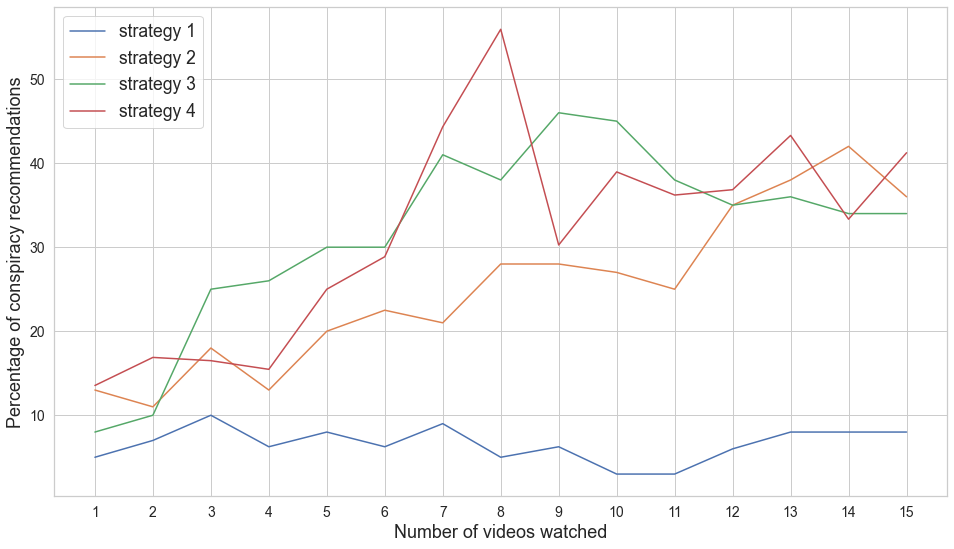

In [70]:
# plot
(grouped["conspiracy_pred"].mean() * 100).unstack(level=0).plot(figsize=(16, 9));

plt.xticks(np.arange(1, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})
plt.show()

In [80]:
# combined[combined["strategy"] == "strategy 3"].groupby(["user", "vids_watched"])["conspiracy_pred"].mean().unstack(level=0).plot(figsize=(16, 9))

# plt.legend()